# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [3]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [83]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [7]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [40]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, 1)

5.006760443547122

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [41]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [103]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))

Gradient check passed!
Gradient check passed!


### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [114]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [116]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [119]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 2.398836
Epoch 1, loss: 2.330387
Epoch 2, loss: 2.311212
Epoch 3, loss: 2.303859
Epoch 4, loss: 2.302782
Epoch 5, loss: 2.302172
Epoch 6, loss: 2.301904
Epoch 7, loss: 2.302429
Epoch 8, loss: 2.302024
Epoch 9, loss: 2.302002


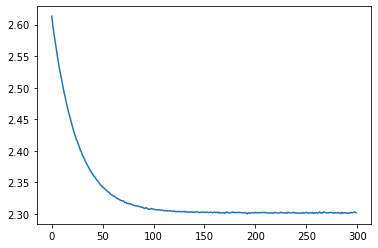

In [120]:
# let's look at the loss history!
plt.plot(loss_history)

In [123]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.125
Epoch 0, loss: 2.302568
Epoch 1, loss: 2.301915
Epoch 2, loss: 2.301670
Epoch 3, loss: 2.301651
Epoch 4, loss: 2.302606
Epoch 5, loss: 2.302616
Epoch 6, loss: 2.301407
Epoch 7, loss: 2.301296
Epoch 8, loss: 2.301311
Epoch 9, loss: 2.301497
Epoch 10, loss: 2.302068
Epoch 11, loss: 2.301988
Epoch 12, loss: 2.301798
Epoch 13, loss: 2.301515
Epoch 14, loss: 2.302763
Epoch 15, loss: 2.301247
Epoch 16, loss: 2.301935
Epoch 17, loss: 2.301691
Epoch 18, loss: 2.301489
Epoch 19, loss: 2.301401
Epoch 20, loss: 2.301218
Epoch 21, loss: 2.301532
Epoch 22, loss: 2.303023
Epoch 23, loss: 2.302017
Epoch 24, loss: 2.301387
Epoch 25, loss: 2.301744
Epoch 26, loss: 2.302303
Epoch 27, loss: 2.301941
Epoch 28, loss: 2.301229
Epoch 29, loss: 2.302482
Epoch 30, loss: 2.302373
Epoch 31, loss: 2.301513
Epoch 32, loss: 2.302127
Epoch 33, loss: 2.302151
Epoch 34, loss: 2.301923
Epoch 35, loss: 2.302624
Epoch 36, loss: 2.301534
Epoch 37, loss: 2.301500
Epoch 38, loss: 2.301506
Epoch 39, loss: 2.

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [142]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
reg_strengths = [1e-2, 1e-4, 1e-5, 1e-6, 1e-8]

best_classifier = None
best_val_accuracy = 0
best_lr, best_reg = 0, 0
# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially

pairs = [(lr, reg) for lr in learning_rates for reg in reg_strengths]
for lr, reg in pairs:
    classifier = linear_classifer.LinearSoftmaxClassifier()
    loss_history = classifier.fit(train_X, train_y, epochs=200, learning_rate=lr, batch_size=batch_size, reg=reg)
    pred = classifier.predict(val_X)
    accuracy = multiclass_accuracy(pred, val_y)
    if accuracy > best_val_accuracy:
        best_classifier = classifier
        best_val_accuracy, best_lr, best_reg = accuracy, lr, reg
print('best validation accuracy achieved: %f' % best_val_accuracy)
print('best lr: %E' % lr)
print('best reg: %E' % reg)

Epoch 0, loss: 2.270960
Epoch 1, loss: 2.242213
Epoch 2, loss: 2.189258
Epoch 3, loss: 2.189510
Epoch 4, loss: 2.152527
Epoch 5, loss: 2.219246
Epoch 6, loss: 2.227797
Epoch 7, loss: 2.187651
Epoch 8, loss: 2.195018
Epoch 9, loss: 2.146701
Epoch 10, loss: 2.195378
Epoch 11, loss: 2.194406
Epoch 12, loss: 2.153455
Epoch 13, loss: 2.170013
Epoch 14, loss: 2.154750
Epoch 15, loss: 2.192294
Epoch 16, loss: 2.193882
Epoch 17, loss: 2.134213
Epoch 18, loss: 2.193976
Epoch 19, loss: 2.136664
Epoch 20, loss: 2.182410
Epoch 21, loss: 2.172934
Epoch 22, loss: 2.165033
Epoch 23, loss: 2.277235
Epoch 24, loss: 2.199249
Epoch 25, loss: 2.199414
Epoch 26, loss: 2.192100
Epoch 27, loss: 2.167412
Epoch 28, loss: 2.174249
Epoch 29, loss: 2.184382
Epoch 30, loss: 2.227426
Epoch 31, loss: 2.162164
Epoch 32, loss: 2.171426
Epoch 33, loss: 2.143967
Epoch 34, loss: 2.216922
Epoch 35, loss: 2.136022
Epoch 36, loss: 2.157888
Epoch 37, loss: 2.204902
Epoch 38, loss: 2.176588
Epoch 39, loss: 2.185514
Epoch 40, 

Epoch 124, loss: 2.035688
Epoch 125, loss: 2.017485
Epoch 126, loss: 2.017408
Epoch 127, loss: 2.053171
Epoch 128, loss: 2.041167
Epoch 129, loss: 2.039127
Epoch 130, loss: 2.059295
Epoch 131, loss: 2.104459
Epoch 132, loss: 2.008000
Epoch 133, loss: 2.047964
Epoch 134, loss: 2.114057
Epoch 135, loss: 2.002399
Epoch 136, loss: 2.026549
Epoch 137, loss: 2.077650
Epoch 138, loss: 2.019586
Epoch 139, loss: 2.073786
Epoch 140, loss: 2.034682
Epoch 141, loss: 2.041403
Epoch 142, loss: 1.977188
Epoch 143, loss: 2.003020
Epoch 144, loss: 2.081379
Epoch 145, loss: 2.043791
Epoch 146, loss: 2.052280
Epoch 147, loss: 2.065336
Epoch 148, loss: 2.038048
Epoch 149, loss: 2.035862
Epoch 150, loss: 2.057635
Epoch 151, loss: 2.006994
Epoch 152, loss: 2.040029
Epoch 153, loss: 2.066998
Epoch 154, loss: 2.053824
Epoch 155, loss: 2.052554
Epoch 156, loss: 2.026630
Epoch 157, loss: 2.001879
Epoch 158, loss: 2.012105
Epoch 159, loss: 2.056122
Epoch 160, loss: 2.073259
Epoch 161, loss: 2.104372
Epoch 162, l

Epoch 46, loss: 2.077778
Epoch 47, loss: 2.048910
Epoch 48, loss: 2.076779
Epoch 49, loss: 2.046448
Epoch 50, loss: 2.104432
Epoch 51, loss: 2.042361
Epoch 52, loss: 2.042457
Epoch 53, loss: 2.121615
Epoch 54, loss: 2.032734
Epoch 55, loss: 2.068103
Epoch 56, loss: 2.136360
Epoch 57, loss: 2.114170
Epoch 58, loss: 2.065497
Epoch 59, loss: 2.099464
Epoch 60, loss: 2.061474
Epoch 61, loss: 2.098951
Epoch 62, loss: 2.118902
Epoch 63, loss: 2.022685
Epoch 64, loss: 2.011984
Epoch 65, loss: 2.119105
Epoch 66, loss: 2.047727
Epoch 67, loss: 2.109831
Epoch 68, loss: 2.043413
Epoch 69, loss: 2.034333
Epoch 70, loss: 2.068148
Epoch 71, loss: 2.099001
Epoch 72, loss: 2.060742
Epoch 73, loss: 2.106122
Epoch 74, loss: 2.095129
Epoch 75, loss: 2.106715
Epoch 76, loss: 2.056241
Epoch 77, loss: 2.007857
Epoch 78, loss: 2.058437
Epoch 79, loss: 2.104003
Epoch 80, loss: 2.061705
Epoch 81, loss: 2.026170
Epoch 82, loss: 2.089796
Epoch 83, loss: 2.058558
Epoch 84, loss: 2.042121
Epoch 85, loss: 2.050283


Epoch 169, loss: 2.038890
Epoch 170, loss: 2.094485
Epoch 171, loss: 1.998474
Epoch 172, loss: 2.060250
Epoch 173, loss: 2.058674
Epoch 174, loss: 2.038255
Epoch 175, loss: 2.027636
Epoch 176, loss: 1.995040
Epoch 177, loss: 2.011500
Epoch 178, loss: 2.046657
Epoch 179, loss: 1.943088
Epoch 180, loss: 1.995138
Epoch 181, loss: 2.038560
Epoch 182, loss: 2.002002
Epoch 183, loss: 2.065084
Epoch 184, loss: 2.031075
Epoch 185, loss: 2.005915
Epoch 186, loss: 2.029115
Epoch 187, loss: 1.938041
Epoch 188, loss: 1.976501
Epoch 189, loss: 1.997144
Epoch 190, loss: 1.995332
Epoch 191, loss: 1.982663
Epoch 192, loss: 1.971187
Epoch 193, loss: 2.034572
Epoch 194, loss: 1.942022
Epoch 195, loss: 1.976710
Epoch 196, loss: 2.031449
Epoch 197, loss: 1.975944
Epoch 198, loss: 2.021793
Epoch 199, loss: 2.014028
Epoch 0, loss: 2.295030
Epoch 1, loss: 2.291392
Epoch 2, loss: 2.280070
Epoch 3, loss: 2.279821
Epoch 4, loss: 2.272521
Epoch 5, loss: 2.262357
Epoch 6, loss: 2.253906
Epoch 7, loss: 2.254966
Ep

Epoch 93, loss: 2.092114
Epoch 94, loss: 2.112852
Epoch 95, loss: 2.188714
Epoch 96, loss: 2.169205
Epoch 97, loss: 2.125765
Epoch 98, loss: 2.162443
Epoch 99, loss: 2.132411
Epoch 100, loss: 2.139324
Epoch 101, loss: 2.083417
Epoch 102, loss: 2.101937
Epoch 103, loss: 2.096457
Epoch 104, loss: 2.140716
Epoch 105, loss: 2.127452
Epoch 106, loss: 2.093656
Epoch 107, loss: 2.076834
Epoch 108, loss: 2.089484
Epoch 109, loss: 2.164177
Epoch 110, loss: 2.100413
Epoch 111, loss: 2.098592
Epoch 112, loss: 2.090780
Epoch 113, loss: 2.108648
Epoch 114, loss: 2.160612
Epoch 115, loss: 2.155610
Epoch 116, loss: 2.159158
Epoch 117, loss: 2.065821
Epoch 118, loss: 2.154741
Epoch 119, loss: 2.091208
Epoch 120, loss: 2.063037
Epoch 121, loss: 2.149302
Epoch 122, loss: 2.093980
Epoch 123, loss: 2.157789
Epoch 124, loss: 2.174874
Epoch 125, loss: 2.149700
Epoch 126, loss: 2.103772
Epoch 127, loss: 2.038692
Epoch 128, loss: 2.110535
Epoch 129, loss: 2.103545
Epoch 130, loss: 2.124836
Epoch 131, loss: 2.

Epoch 14, loss: 2.226855
Epoch 15, loss: 2.223001
Epoch 16, loss: 2.199909
Epoch 17, loss: 2.198968
Epoch 18, loss: 2.199910
Epoch 19, loss: 2.185376
Epoch 20, loss: 2.185207
Epoch 21, loss: 2.221964
Epoch 22, loss: 2.217602
Epoch 23, loss: 2.182627
Epoch 24, loss: 2.187703
Epoch 25, loss: 2.221480
Epoch 26, loss: 2.219789
Epoch 27, loss: 2.198920
Epoch 28, loss: 2.197766
Epoch 29, loss: 2.182984
Epoch 30, loss: 2.155675
Epoch 31, loss: 2.234787
Epoch 32, loss: 2.182421
Epoch 33, loss: 2.177524
Epoch 34, loss: 2.194436
Epoch 35, loss: 2.180664
Epoch 36, loss: 2.194928
Epoch 37, loss: 2.182782
Epoch 38, loss: 2.183924
Epoch 39, loss: 2.158812
Epoch 40, loss: 2.162972
Epoch 41, loss: 2.196221
Epoch 42, loss: 2.172561
Epoch 43, loss: 2.145746
Epoch 44, loss: 2.188495
Epoch 45, loss: 2.128312
Epoch 46, loss: 2.171709
Epoch 47, loss: 2.151302
Epoch 48, loss: 2.121348
Epoch 49, loss: 2.141611
Epoch 50, loss: 2.103404
Epoch 51, loss: 2.124421
Epoch 52, loss: 2.167918
Epoch 53, loss: 2.148726


Epoch 137, loss: 2.143387
Epoch 138, loss: 2.109495
Epoch 139, loss: 2.146043
Epoch 140, loss: 2.146005
Epoch 141, loss: 2.060472
Epoch 142, loss: 2.118901
Epoch 143, loss: 2.123248
Epoch 144, loss: 2.114780
Epoch 145, loss: 2.154848
Epoch 146, loss: 2.111309
Epoch 147, loss: 2.171367
Epoch 148, loss: 2.085219
Epoch 149, loss: 2.143537
Epoch 150, loss: 2.080967
Epoch 151, loss: 2.105290
Epoch 152, loss: 2.115662
Epoch 153, loss: 2.122159
Epoch 154, loss: 2.086644
Epoch 155, loss: 2.099451
Epoch 156, loss: 2.092630
Epoch 157, loss: 2.151299
Epoch 158, loss: 2.123555
Epoch 159, loss: 2.120283
Epoch 160, loss: 2.106407
Epoch 161, loss: 2.115122
Epoch 162, loss: 2.135401
Epoch 163, loss: 2.068678
Epoch 164, loss: 2.056566
Epoch 165, loss: 2.091403
Epoch 166, loss: 2.139275
Epoch 167, loss: 2.081911
Epoch 168, loss: 2.093416
Epoch 169, loss: 2.065044
Epoch 170, loss: 2.081888
Epoch 171, loss: 2.122342
Epoch 172, loss: 2.092420
Epoch 173, loss: 2.089654
Epoch 174, loss: 2.118074
Epoch 175, l

Epoch 59, loss: 2.273248
Epoch 60, loss: 2.255832
Epoch 61, loss: 2.256739
Epoch 62, loss: 2.263637
Epoch 63, loss: 2.254804
Epoch 64, loss: 2.256929
Epoch 65, loss: 2.264838
Epoch 66, loss: 2.245203
Epoch 67, loss: 2.260006
Epoch 68, loss: 2.259320
Epoch 69, loss: 2.251571
Epoch 70, loss: 2.254979
Epoch 71, loss: 2.252347
Epoch 72, loss: 2.242372
Epoch 73, loss: 2.248703
Epoch 74, loss: 2.236320
Epoch 75, loss: 2.245874
Epoch 76, loss: 2.239554
Epoch 77, loss: 2.252056
Epoch 78, loss: 2.251420
Epoch 79, loss: 2.243912
Epoch 80, loss: 2.261236
Epoch 81, loss: 2.260246
Epoch 82, loss: 2.240311
Epoch 83, loss: 2.249430
Epoch 84, loss: 2.241492
Epoch 85, loss: 2.240520
Epoch 86, loss: 2.240222
Epoch 87, loss: 2.241184
Epoch 88, loss: 2.230109
Epoch 89, loss: 2.240663
Epoch 90, loss: 2.234475
Epoch 91, loss: 2.227877
Epoch 92, loss: 2.250312
Epoch 93, loss: 2.235062
Epoch 94, loss: 2.236072
Epoch 95, loss: 2.241638
Epoch 96, loss: 2.230548
Epoch 97, loss: 2.241209
Epoch 98, loss: 2.231199


Epoch 181, loss: 2.189577
Epoch 182, loss: 2.219574
Epoch 183, loss: 2.215018
Epoch 184, loss: 2.176693
Epoch 185, loss: 2.205571
Epoch 186, loss: 2.203057
Epoch 187, loss: 2.195121
Epoch 188, loss: 2.220974
Epoch 189, loss: 2.188181
Epoch 190, loss: 2.221858
Epoch 191, loss: 2.185973
Epoch 192, loss: 2.200138
Epoch 193, loss: 2.228920
Epoch 194, loss: 2.188996
Epoch 195, loss: 2.209757
Epoch 196, loss: 2.214205
Epoch 197, loss: 2.198565
Epoch 198, loss: 2.209045
Epoch 199, loss: 2.208988
Epoch 0, loss: 2.301782
Epoch 1, loss: 2.300362
Epoch 2, loss: 2.299210
Epoch 3, loss: 2.297803
Epoch 4, loss: 2.298412
Epoch 5, loss: 2.297512
Epoch 6, loss: 2.296411
Epoch 7, loss: 2.294533
Epoch 8, loss: 2.294100
Epoch 9, loss: 2.296707
Epoch 10, loss: 2.291404
Epoch 11, loss: 2.294812
Epoch 12, loss: 2.290006
Epoch 13, loss: 2.290741
Epoch 14, loss: 2.287997
Epoch 15, loss: 2.286429
Epoch 16, loss: 2.288654
Epoch 17, loss: 2.287913
Epoch 18, loss: 2.282513
Epoch 19, loss: 2.281684
Epoch 20, loss: 

Epoch 106, loss: 2.230884
Epoch 107, loss: 2.231585
Epoch 108, loss: 2.232545
Epoch 109, loss: 2.217759
Epoch 110, loss: 2.231775
Epoch 111, loss: 2.236815
Epoch 112, loss: 2.236061
Epoch 113, loss: 2.239264
Epoch 114, loss: 2.220037
Epoch 115, loss: 2.219577
Epoch 116, loss: 2.221495
Epoch 117, loss: 2.214382
Epoch 118, loss: 2.241382
Epoch 119, loss: 2.225607
Epoch 120, loss: 2.223226
Epoch 121, loss: 2.219995
Epoch 122, loss: 2.244085
Epoch 123, loss: 2.219875
Epoch 124, loss: 2.212518
Epoch 125, loss: 2.244322
Epoch 126, loss: 2.221867
Epoch 127, loss: 2.214386
Epoch 128, loss: 2.215522
Epoch 129, loss: 2.215106
Epoch 130, loss: 2.230864
Epoch 131, loss: 2.217123
Epoch 132, loss: 2.219547
Epoch 133, loss: 2.229217
Epoch 134, loss: 2.223868
Epoch 135, loss: 2.226166
Epoch 136, loss: 2.242390
Epoch 137, loss: 2.222646
Epoch 138, loss: 2.235816
Epoch 139, loss: 2.181422
Epoch 140, loss: 2.247048
Epoch 141, loss: 2.229135
Epoch 142, loss: 2.212850
Epoch 143, loss: 2.219918
Epoch 144, l

Epoch 27, loss: 2.299645
Epoch 28, loss: 2.299884
Epoch 29, loss: 2.298824
Epoch 30, loss: 2.299483
Epoch 31, loss: 2.299921
Epoch 32, loss: 2.298733
Epoch 33, loss: 2.298123
Epoch 34, loss: 2.298665
Epoch 35, loss: 2.300923
Epoch 36, loss: 2.300157
Epoch 37, loss: 2.298604
Epoch 38, loss: 2.299468
Epoch 39, loss: 2.297732
Epoch 40, loss: 2.298712
Epoch 41, loss: 2.297965
Epoch 42, loss: 2.298822
Epoch 43, loss: 2.299631
Epoch 44, loss: 2.298581
Epoch 45, loss: 2.297701
Epoch 46, loss: 2.295580
Epoch 47, loss: 2.296143
Epoch 48, loss: 2.297154
Epoch 49, loss: 2.296664
Epoch 50, loss: 2.300894
Epoch 51, loss: 2.296887
Epoch 52, loss: 2.296199
Epoch 53, loss: 2.298274
Epoch 54, loss: 2.299005
Epoch 55, loss: 2.299881
Epoch 56, loss: 2.296339
Epoch 57, loss: 2.295383
Epoch 58, loss: 2.297588
Epoch 59, loss: 2.296083
Epoch 60, loss: 2.297880
Epoch 61, loss: 2.294473
Epoch 62, loss: 2.294619
Epoch 63, loss: 2.297331
Epoch 64, loss: 2.295824
Epoch 65, loss: 2.297591
Epoch 66, loss: 2.294904


Epoch 151, loss: 2.286711
Epoch 152, loss: 2.290048
Epoch 153, loss: 2.283408
Epoch 154, loss: 2.287492
Epoch 155, loss: 2.287417
Epoch 156, loss: 2.288098
Epoch 157, loss: 2.290057
Epoch 158, loss: 2.289908
Epoch 159, loss: 2.290203
Epoch 160, loss: 2.291356
Epoch 161, loss: 2.287027
Epoch 162, loss: 2.290704
Epoch 163, loss: 2.286389
Epoch 164, loss: 2.288741
Epoch 165, loss: 2.290569
Epoch 166, loss: 2.289698
Epoch 167, loss: 2.287305
Epoch 168, loss: 2.288342
Epoch 169, loss: 2.286894
Epoch 170, loss: 2.283847
Epoch 171, loss: 2.284443
Epoch 172, loss: 2.289415
Epoch 173, loss: 2.285372
Epoch 174, loss: 2.285251
Epoch 175, loss: 2.289296
Epoch 176, loss: 2.295229
Epoch 177, loss: 2.289376
Epoch 178, loss: 2.286837
Epoch 179, loss: 2.290344
Epoch 180, loss: 2.290216
Epoch 181, loss: 2.284754
Epoch 182, loss: 2.286472
Epoch 183, loss: 2.285937
Epoch 184, loss: 2.281603
Epoch 185, loss: 2.287827
Epoch 186, loss: 2.291780
Epoch 187, loss: 2.288206
Epoch 188, loss: 2.285926
Epoch 189, l

Epoch 74, loss: 2.297303
Epoch 75, loss: 2.295002
Epoch 76, loss: 2.295015
Epoch 77, loss: 2.294726
Epoch 78, loss: 2.296064
Epoch 79, loss: 2.295792
Epoch 80, loss: 2.293209
Epoch 81, loss: 2.298162
Epoch 82, loss: 2.293971
Epoch 83, loss: 2.292858
Epoch 84, loss: 2.292832
Epoch 85, loss: 2.298617
Epoch 86, loss: 2.293834
Epoch 87, loss: 2.294396
Epoch 88, loss: 2.292095
Epoch 89, loss: 2.294548
Epoch 90, loss: 2.290315
Epoch 91, loss: 2.294092
Epoch 92, loss: 2.298994
Epoch 93, loss: 2.293052
Epoch 94, loss: 2.293477
Epoch 95, loss: 2.293873
Epoch 96, loss: 2.296910
Epoch 97, loss: 2.293297
Epoch 98, loss: 2.293157
Epoch 99, loss: 2.292270
Epoch 100, loss: 2.291667
Epoch 101, loss: 2.294323
Epoch 102, loss: 2.294057
Epoch 103, loss: 2.293315
Epoch 104, loss: 2.293716
Epoch 105, loss: 2.292767
Epoch 106, loss: 2.291922
Epoch 107, loss: 2.292257
Epoch 108, loss: 2.294458
Epoch 109, loss: 2.291196
Epoch 110, loss: 2.292652
Epoch 111, loss: 2.291379
Epoch 112, loss: 2.294492
Epoch 113, l

Epoch 196, loss: 2.301249
Epoch 197, loss: 2.301481
Epoch 198, loss: 2.299689
Epoch 199, loss: 2.300487
Epoch 0, loss: 2.302422
Epoch 1, loss: 2.302388
Epoch 2, loss: 2.302342
Epoch 3, loss: 2.303760
Epoch 4, loss: 2.303398
Epoch 5, loss: 2.302811
Epoch 6, loss: 2.302362
Epoch 7, loss: 2.301642
Epoch 8, loss: 2.302887
Epoch 9, loss: 2.301962
Epoch 10, loss: 2.302335
Epoch 11, loss: 2.302364
Epoch 12, loss: 2.302475
Epoch 13, loss: 2.302889
Epoch 14, loss: 2.303353
Epoch 15, loss: 2.302376
Epoch 16, loss: 2.302686
Epoch 17, loss: 2.302277
Epoch 18, loss: 2.302409
Epoch 19, loss: 2.301909
Epoch 20, loss: 2.302911
Epoch 21, loss: 2.301587
Epoch 22, loss: 2.301667
Epoch 23, loss: 2.302075
Epoch 24, loss: 2.302349
Epoch 25, loss: 2.301674
Epoch 26, loss: 2.301951
Epoch 27, loss: 2.302431
Epoch 28, loss: 2.302310
Epoch 29, loss: 2.301830
Epoch 30, loss: 2.302403
Epoch 31, loss: 2.302648
Epoch 32, loss: 2.302106
Epoch 33, loss: 2.301947
Epoch 34, loss: 2.302556
Epoch 35, loss: 2.302515
Epoch 

Epoch 121, loss: 2.302172
Epoch 122, loss: 2.300983
Epoch 123, loss: 2.301366
Epoch 124, loss: 2.301628
Epoch 125, loss: 2.301421
Epoch 126, loss: 2.300984
Epoch 127, loss: 2.301385
Epoch 128, loss: 2.300624
Epoch 129, loss: 2.301032
Epoch 130, loss: 2.300902
Epoch 131, loss: 2.300210
Epoch 132, loss: 2.301482
Epoch 133, loss: 2.300785
Epoch 134, loss: 2.300452
Epoch 135, loss: 2.301065
Epoch 136, loss: 2.301068
Epoch 137, loss: 2.300034
Epoch 138, loss: 2.300943
Epoch 139, loss: 2.300362
Epoch 140, loss: 2.301579
Epoch 141, loss: 2.299568
Epoch 142, loss: 2.301896
Epoch 143, loss: 2.300966
Epoch 144, loss: 2.302060
Epoch 145, loss: 2.301306
Epoch 146, loss: 2.300868
Epoch 147, loss: 2.301227
Epoch 148, loss: 2.299941
Epoch 149, loss: 2.300715
Epoch 150, loss: 2.301661
Epoch 151, loss: 2.301693
Epoch 152, loss: 2.300618
Epoch 153, loss: 2.299858
Epoch 154, loss: 2.301207
Epoch 155, loss: 2.300854
Epoch 156, loss: 2.301857
Epoch 157, loss: 2.299805
Epoch 158, loss: 2.300520
Epoch 159, l

Epoch 44, loss: 2.302276
Epoch 45, loss: 2.302605
Epoch 46, loss: 2.301791
Epoch 47, loss: 2.302611
Epoch 48, loss: 2.302570
Epoch 49, loss: 2.301995
Epoch 50, loss: 2.303614
Epoch 51, loss: 2.301191
Epoch 52, loss: 2.302446
Epoch 53, loss: 2.302656
Epoch 54, loss: 2.301412
Epoch 55, loss: 2.302355
Epoch 56, loss: 2.302875
Epoch 57, loss: 2.302658
Epoch 58, loss: 2.302458
Epoch 59, loss: 2.302885
Epoch 60, loss: 2.302141
Epoch 61, loss: 2.302824
Epoch 62, loss: 2.302457
Epoch 63, loss: 2.302063
Epoch 64, loss: 2.302149
Epoch 65, loss: 2.301428
Epoch 66, loss: 2.303101
Epoch 67, loss: 2.302413
Epoch 68, loss: 2.302684
Epoch 69, loss: 2.302294
Epoch 70, loss: 2.303465
Epoch 71, loss: 2.302376
Epoch 72, loss: 2.302175
Epoch 73, loss: 2.301902
Epoch 74, loss: 2.301907
Epoch 75, loss: 2.301103
Epoch 76, loss: 2.302071
Epoch 77, loss: 2.302448
Epoch 78, loss: 2.301794
Epoch 79, loss: 2.302864
Epoch 80, loss: 2.302654
Epoch 81, loss: 2.302083
Epoch 82, loss: 2.302104
Epoch 83, loss: 2.302576


Epoch 166, loss: 2.301661
Epoch 167, loss: 2.303144
Epoch 168, loss: 2.303217
Epoch 169, loss: 2.302761
Epoch 170, loss: 2.303843
Epoch 171, loss: 2.302293
Epoch 172, loss: 2.303568
Epoch 173, loss: 2.302058
Epoch 174, loss: 2.303211
Epoch 175, loss: 2.303054
Epoch 176, loss: 2.302017
Epoch 177, loss: 2.302452
Epoch 178, loss: 2.302652
Epoch 179, loss: 2.303061
Epoch 180, loss: 2.302797
Epoch 181, loss: 2.302455
Epoch 182, loss: 2.302682
Epoch 183, loss: 2.301219
Epoch 184, loss: 2.303375
Epoch 185, loss: 2.303475
Epoch 186, loss: 2.303828
Epoch 187, loss: 2.302442
Epoch 188, loss: 2.303390
Epoch 189, loss: 2.302812
Epoch 190, loss: 2.302173
Epoch 191, loss: 2.302587
Epoch 192, loss: 2.303663
Epoch 193, loss: 2.301769
Epoch 194, loss: 2.303203
Epoch 195, loss: 2.303634
Epoch 196, loss: 2.303623
Epoch 197, loss: 2.303807
Epoch 198, loss: 2.302237
Epoch 199, loss: 2.302605
Epoch 0, loss: 2.302371
Epoch 1, loss: 2.302257
Epoch 2, loss: 2.302658
Epoch 3, loss: 2.302796
Epoch 4, loss: 2.302

Epoch 91, loss: 2.302975
Epoch 92, loss: 2.302608
Epoch 93, loss: 2.302727
Epoch 94, loss: 2.301668
Epoch 95, loss: 2.301937
Epoch 96, loss: 2.302452
Epoch 97, loss: 2.302679
Epoch 98, loss: 2.302409
Epoch 99, loss: 2.303175
Epoch 100, loss: 2.303051
Epoch 101, loss: 2.303049
Epoch 102, loss: 2.302873
Epoch 103, loss: 2.302138
Epoch 104, loss: 2.302539
Epoch 105, loss: 2.302607
Epoch 106, loss: 2.303005
Epoch 107, loss: 2.302818
Epoch 108, loss: 2.301916
Epoch 109, loss: 2.302134
Epoch 110, loss: 2.301938
Epoch 111, loss: 2.303331
Epoch 112, loss: 2.301440
Epoch 113, loss: 2.301660
Epoch 114, loss: 2.303301
Epoch 115, loss: 2.302390
Epoch 116, loss: 2.302435
Epoch 117, loss: 2.302755
Epoch 118, loss: 2.302403
Epoch 119, loss: 2.302642
Epoch 120, loss: 2.302770
Epoch 121, loss: 2.302004
Epoch 122, loss: 2.301613
Epoch 123, loss: 2.302535
Epoch 124, loss: 2.302701
Epoch 125, loss: 2.302745
Epoch 126, loss: 2.302385
Epoch 127, loss: 2.302634
Epoch 128, loss: 2.303038
Epoch 129, loss: 2.30

Epoch 13, loss: 2.302974
Epoch 14, loss: 2.303207
Epoch 15, loss: 2.303016
Epoch 16, loss: 2.303117
Epoch 17, loss: 2.302741
Epoch 18, loss: 2.302633
Epoch 19, loss: 2.302729
Epoch 20, loss: 2.303668
Epoch 21, loss: 2.302622
Epoch 22, loss: 2.301961
Epoch 23, loss: 2.302909
Epoch 24, loss: 2.302199
Epoch 25, loss: 2.302153
Epoch 26, loss: 2.302467
Epoch 27, loss: 2.303247
Epoch 28, loss: 2.302695
Epoch 29, loss: 2.302435
Epoch 30, loss: 2.302325
Epoch 31, loss: 2.303012
Epoch 32, loss: 2.302093
Epoch 33, loss: 2.301672
Epoch 34, loss: 2.303120
Epoch 35, loss: 2.302740
Epoch 36, loss: 2.302510
Epoch 37, loss: 2.302224
Epoch 38, loss: 2.302235
Epoch 39, loss: 2.302569
Epoch 40, loss: 2.302405
Epoch 41, loss: 2.301794
Epoch 42, loss: 2.302836
Epoch 43, loss: 2.302065
Epoch 44, loss: 2.302825
Epoch 45, loss: 2.302746
Epoch 46, loss: 2.303618
Epoch 47, loss: 2.302554
Epoch 48, loss: 2.302884
Epoch 49, loss: 2.302554
Epoch 50, loss: 2.302631
Epoch 51, loss: 2.302892
Epoch 52, loss: 2.302446


Epoch 136, loss: 2.302573
Epoch 137, loss: 2.303074
Epoch 138, loss: 2.302188
Epoch 139, loss: 2.303744
Epoch 140, loss: 2.304717
Epoch 141, loss: 2.303451
Epoch 142, loss: 2.303376
Epoch 143, loss: 2.302712
Epoch 144, loss: 2.302099
Epoch 145, loss: 2.301642
Epoch 146, loss: 2.302758
Epoch 147, loss: 2.304509
Epoch 148, loss: 2.302404
Epoch 149, loss: 2.302294
Epoch 150, loss: 2.302635
Epoch 151, loss: 2.303796
Epoch 152, loss: 2.302670
Epoch 153, loss: 2.303324
Epoch 154, loss: 2.303492
Epoch 155, loss: 2.301432
Epoch 156, loss: 2.302484
Epoch 157, loss: 2.303250
Epoch 158, loss: 2.302808
Epoch 159, loss: 2.302120
Epoch 160, loss: 2.303632
Epoch 161, loss: 2.302923
Epoch 162, loss: 2.303617
Epoch 163, loss: 2.303056
Epoch 164, loss: 2.302591
Epoch 165, loss: 2.303850
Epoch 166, loss: 2.303248
Epoch 167, loss: 2.303484
Epoch 168, loss: 2.303512
Epoch 169, loss: 2.302018
Epoch 170, loss: 2.302941
Epoch 171, loss: 2.302627
Epoch 172, loss: 2.302841
Epoch 173, loss: 2.302421
Epoch 174, l

Epoch 59, loss: 2.302754
Epoch 60, loss: 2.301895
Epoch 61, loss: 2.302730
Epoch 62, loss: 2.302853
Epoch 63, loss: 2.302493
Epoch 64, loss: 2.303269
Epoch 65, loss: 2.302876
Epoch 66, loss: 2.301948
Epoch 67, loss: 2.302504
Epoch 68, loss: 2.301982
Epoch 69, loss: 2.301677
Epoch 70, loss: 2.302827
Epoch 71, loss: 2.302448
Epoch 72, loss: 2.301092
Epoch 73, loss: 2.302273
Epoch 74, loss: 2.303279
Epoch 75, loss: 2.302390
Epoch 76, loss: 2.303214
Epoch 77, loss: 2.303192
Epoch 78, loss: 2.302640
Epoch 79, loss: 2.302827
Epoch 80, loss: 2.302834
Epoch 81, loss: 2.303040
Epoch 82, loss: 2.301403
Epoch 83, loss: 2.302485
Epoch 84, loss: 2.302912
Epoch 85, loss: 2.302629
Epoch 86, loss: 2.302520
Epoch 87, loss: 2.302703
Epoch 88, loss: 2.302752
Epoch 89, loss: 2.302622
Epoch 90, loss: 2.302716
Epoch 91, loss: 2.301916
Epoch 92, loss: 2.302833
Epoch 93, loss: 2.302896
Epoch 94, loss: 2.302970
Epoch 95, loss: 2.302568
Epoch 96, loss: 2.302522
Epoch 97, loss: 2.302270
Epoch 98, loss: 2.303017


Epoch 181, loss: 2.303682
Epoch 182, loss: 2.302595
Epoch 183, loss: 2.303426
Epoch 184, loss: 2.302737
Epoch 185, loss: 2.302200
Epoch 186, loss: 2.303160
Epoch 187, loss: 2.303183
Epoch 188, loss: 2.301412
Epoch 189, loss: 2.303712
Epoch 190, loss: 2.301986
Epoch 191, loss: 2.303937
Epoch 192, loss: 2.302061
Epoch 193, loss: 2.302529
Epoch 194, loss: 2.302691
Epoch 195, loss: 2.302070
Epoch 196, loss: 2.303099
Epoch 197, loss: 2.302579
Epoch 198, loss: 2.302523
Epoch 199, loss: 2.302927
Epoch 0, loss: 2.302769
Epoch 1, loss: 2.302353
Epoch 2, loss: 2.302658
Epoch 3, loss: 2.301184
Epoch 4, loss: 2.301821
Epoch 5, loss: 2.303835
Epoch 6, loss: 2.303217
Epoch 7, loss: 2.303384
Epoch 8, loss: 2.302836
Epoch 9, loss: 2.302626
Epoch 10, loss: 2.302631
Epoch 11, loss: 2.302774
Epoch 12, loss: 2.303011
Epoch 13, loss: 2.303337
Epoch 14, loss: 2.302431
Epoch 15, loss: 2.301386
Epoch 16, loss: 2.303990
Epoch 17, loss: 2.301934
Epoch 18, loss: 2.301318
Epoch 19, loss: 2.303015
Epoch 20, loss: 

# Какой же точности мы добились на тестовых данных?

In [143]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.207000
